Open this notebook in nbviewer to use the links. http://jiffyclub.github.io/open-in-nbviewer/

# Abstract
Electric vehicle (EV) manufacturer, Tesla, has been seen as a disruptive force in the auto-industry<sup>1</sup>. 
Indeed such growth is likened to the tech industry or even comparable to an entirely new industry<sup>2</sup>.<br/>  
By comparing quarterly balance sheets from US-based auto and tech companies over the past thirteen years, we explore if there is evidence from an asset-and-liabilities perspective to support such claims. <br/> 

This 2-part study will first attempt to validate the assumption that tech and auto industries are different with respect to their balance sheet and if the assumptions hold the second part will explore non-directional supporting evidence for the classification of Tesla into either Tech or Auto also only with regards to the balance sheet.<br/>

<br/>

RFECV<a id='top'><a/>
## Table of Contents
    
### Methodology Overview
    
### Exploratory Data Analysis 
    
#### 1) Transforming time series data into de-trended, scaled and normalised format (i.i.d.) for tabular classification. 
    
   [Experiment 1.1 - grouping all companies as a whole for one transformation.](#expt1.1)
    
   [Pipeline and Hyperparameter Tuning](#pipe&Hyper)
    
   [Experiment 2.2 - individually transforming within companies across the same time-frame](#expt1.2)

#### 2) Use Statistics 
   [Experiment 2.1 - MANOVA](#expt2.1)
    
#### 3) Use Cluster Analysis 
   [Experiment 3.1 - k-means](#expt3.1)
    
#### 4) Use Sktime
   [Experiment 4.1 - ML Time Series Analysis](#expt4.1)

   [Appendix](#appendix)

## Data 
Data was manually **web scraped** from the SEC website.<br />
- See my [web_scraping_sec](https://github.com/mcsw311093/web_scraping_sec) repo for web-scraping with BeautifulSoup4 (BS4).


The whole process of **data-cleaning** can be found in [Data-Cleaning.ipynb](https://github.com/mcsw311093/Data-Cleaning-and-Analysis/blob/master/Data-Cleaning.ipynb) of the current repo.


# Aim and Motivation (Introduction)
##### Background
Finance Background 
Valuating a company is a difficult task.  Especially during these times of new companies disrupting different  industry. 

	- Classification role in Valuation
	Classification effects analyst and general public's perception of company value, internally (Assets) and externally (Sentiments, brand-loyalty)

	- Balance Sheet: an internal view of monetary value 
	Therefore, this study will focus on the effects of internal value on sector  classification, where internal value is represented by constituents of the balance sheet. 

Data Science background

    - Traditional means of analysis using machine learning have focused on  a particular distribution of data viz. Independent and identically distributed random variables.
    
    - Recent interest incorporating the time component of data has been seen (reference) with the development of  sktime API in sklearn, tsCV and tseries package in R. 
    
    - This study will compare the results of statistics methods and machine learning models. 

Therefore, this study will first address concerns that the difference in industry sectors is sufficiently represented in the quarterly and annual balance sheets.

If the above assumption holds, we will continue exploring the relationship between our target company (Tesla) and each industry. 

Finally, we will end our analysis with post-hoc analysis of the relationship of our chosen IVs and DVs. 

<br/>


##### Research Question
*Limitation: All comparisons and classifications are  **exclusively** based on shared data found in balance sheets of each company.<br/>*

ML and Statistics approach to solve 2 problems:
1) Testing our assumption distinct industries (population) can be inferred from the difference in variance within the balance sheet (sample).
Test Assumption: Distinct Industries on gernalized 'Balance Sheet' construct 
(Auto-industry != Tech-industry)

2) Explore
Can Tesla be classified into either one? Or neither? Or what percentage of Tesla's Assets and Liabilites resembles either industries.

To find support that the differences in industries are reflected in the balance sheet,

we will use multiple independent t-tests for each feature to see if there is any statistically significant difference in the pattern of each DV.

#### Approach & Experimental Set-up
###### **Part 1**
Exploratory data analysis and significance testing will be conducted to explore the **difference between the target industries.** <br/>
 - Ha: The sample means are different. <br/>
H0: The sample means are the same. (Reject?) <br/>
Method: (1) ML - Clustering; (2) Statistics - Factorial Analysis / Profile Analysis (Focus between groups)<br/>

###### **Part 2**
The percentage of **Tesla's balance sheet resembles** either one of our target industries' balance sheet. <br/>
- Ha1: Explore how much of Tesla is similar to Tech in comparison to Auto.<br/>
H01: Not applicable<br/>
Method: Logistic Regression & AUROC score, where the postive class is Auto <br/>

- Ha2: Explore how much of Tesla is similar to Auto in comparison to Tech.<br/>
H02: Not applicable<br/>
Method: Logistic Regression & AUROC score, where the postive class is Tech


###### **Post-hoc analysis**: **Interaction and main effects** between industries over time while controlling for Total Assets covariate.
- Ha: Industry dichotomy effects and interaction affect the balance sheet, if we control for Total_Assets.<br/>
H0: Regarding industry specific interactions and main effects, none detected on the balance sheet while controlling for Total_Assets. <br/>
Method: MANCOVA (Focus on DV construct) OR generalized linear model https://www.ibm.com/support/knowledgecenter/de/SSLVMB_24.0.0/spss/advanced/idh_idd_genlin_typeofmodel.html#idh_idd_genlin_typeofmodel
<br/>

###### **Post-hoc hypothesis**: 
<br/>
<br/>
<sup>1</sup>https://www.businessinsider.com/tesla-stock-value-compared-ford-gm-fca-car-production-charts-2020-7<br />
<sup>2</sup>https://www.investopedia.com/news/tesla-tech-company-or-car-company/

## Import Libraries

In [1]:
# import dataframe and libraries
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

# Function for creating model pipelines
from sklearn.pipeline import make_pipeline

# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Function for splitting training and test set
from sklearn.model_selection import train_test_split

# Classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# GridSearchCV
from sklearn.model_selection import GridSearchCV
import seaborn as sns 
sns.set_style('darkgrid')
import altair as alt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', None)

from IPython.display import display
from IPython.core import display as ICD


Bad key "text.kerning_factor" on line 4 in
C:\Users\Matthew\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Power Transform
from sklearn.preprocessing import power_transform

from scipy.stats import boxcox
from scipy.stats import yeojohnson

# Difference computation function
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# StandardScaler
from sklearn.preprocessing import StandardScaler

# Normalization
from sklearn.preprocessing import MinMaxScaler

In [3]:
main_df = pd.read_csv('abt.csv')

In [4]:
main_df.groupby(main_df['company_name'], sort=True).sum()

,Year,Accounts Receivable,Inventory,Total current assets,Total current liabilities,Total liabilities,Common Stock,Total liabilities and equity,New Deferred Revenue,New Property and Equipment,Total Non-Current Assets,Total_Assets,Non-Current Liabilities,Total Shareholder's Equity,Accounts Payables,Retained Earning,OCI,Accounts_Receivable_missing,Common_Stock_missing,Short_term_investments,Short_term_investments_missing,Inventory_missing,current_ratio,quick_ratio,debt_ratio,debt_to_equity_ratio,equity_multiplier,industry
company_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Amazon,100675,2.829430e+11,3.825570e+11,1.428235e+12,1.301270e+12,2.219730e+12,2.410000e+08,3044300000000,1.271290e+11,1.046805e+12,2.108220e+11,3.044300e+12,9.184600e+11,8.245700e+11,7.327650e+11,2.964710e+11,2.222100e+10,0,0,2.756270e+11,0,0,59.065070,42.640448,34.963018,130.548865,180.548865,50.0
Apple,52429,3.975220e+11,8.578300e+10,2.800189e+12,2.125556e+12,5.016973e+12,8.655780e+11,8110972000000,2.627400e+11,7.421370e+11,1.740391e+12,8.110972e+12,2.184731e+12,3.093999e+12,9.117180e+11,2.245244e+12,3.245900e+10,0,0,3.774262e+12,7,0,34.278200,33.245377,15.750090,43.698300,69.698300,26.0
Facebook,44374,1.021680e+11,0.000000e+00,8.812530e+11,1.201380e+11,2.715360e+11,0.000000e+00,1752395000000,2.474000e+09,3.430340e+11,8.617100e+10,1.752395e+12,1.097640e+11,2.789311e+12,9.619000e+09,6.261750e+11,1.067900e+10,0,22,5.449710e+11,0,22,209.655930,209.655930,3.006712,1.913864,13.727506,22.0
Ford,60480,4.271477e+12,3.004110e+11,3.144905e+12,2.622717e+12,6.070087e+12,1.188000e+09,6941199000000,1.209010e+12,9.493500e+11,3.796294e+12,6.941199e+12,1.301248e+12,8.665520e+11,6.549910e+11,6.151340e+11,3.666120e+11,0,0,6.122080e+11,0,0,35.919542,32.394452,26.276471,217.926688,248.112358,0.0
GM,86618,1.644996e+12,5.700550e+11,3.200108e+12,2.963690e+12,6.241944e+12,5.930000e+08,7959308000000,1.268860e+12,2.115283e+12,4.846485e+12,7.959308e+12,3.278254e+12,1.627338e+12,1.051662e+12,6.460360e+11,2.701340e+11,0,2,3.161520e+11,3,0,47.476217,38.794746,33.521496,168.980508,214.518253,0.0
Google,38330,3.111810e+11,1.197800e+10,2.279091e+12,5.004500e+11,8.594560e+11,7.801800e+11,3849115000000,3.170500e+10,9.026310e+11,5.296800e+10,3.849115e+12,6.940200e+10,3.010023e+12,5.818300e+10,2.257396e+12,2.755300e+10,0,0,1.583755e+12,0,4,93.089222,92.671373,4.140259,5.295098,24.123270,19.0
Microsoft,64504,5.313600e+11,7.394500e+10,4.296721e+12,1.558512e+12,3.847046e+12,2.248386e+12,6524922000000,8.558170e+11,6.628030e+11,3.780890e+11,6.524922e+12,1.406331e+12,2.677876e+12,2.150510e+11,3.924650e+11,5.902300e+10,0,0,3.214832e+12,0,0,88.989467,87.415692,18.176794,46.010661,78.010661,32.0
Netflix,96672,0.000000e+00,8.930012e+13,4.731783e+13,3.558797e+13,9.812288e+13,9.938387e+12,124929670160000,4.226629e+12,2.671635e+12,5.674708e+12,1.249297e+14,2.205699e+12,2.680679e+13,2.984036e+12,1.438237e+13,1.688469e+11,48,0,3.380962e+12,10,1,66.778027,-5.657607,35.801000,158.649349,206.649349,48.0
Tesla,44374,1.344071e+10,5.293356e+10,1.465474e+11,1.450426e+11,3.730633e+11,2.932000e+06,477577304000,3.292231e+10,1.611449e+11,1.146351e+10,4.775773e+11,1.749331e+11,8.476468e+10,4.905543e+10,8.901459e+10,9.630870e+08,0,3,1.792980e+08,14,0,23.363573,14.832870,17.539468,108.706417,134.864269,0.0


In [5]:
main_df.shape

(292, 30)

In [6]:
tesla_df = main_df.loc[main_df['company_name']=='Tesla']

In [7]:
tsla_index = main_df.loc[main_df['company_name']=='Tesla'].index

In [8]:
tsla_index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
            19, 20, 21],
           dtype='int64')

In [9]:
main_df.drop(index= tsla_index, inplace=True)

In [10]:
main_df.shape

(270, 30)

# Methodology Overview

Previously we have handled missing data and feature engineering in another file therefore we will not re-do that here; we will start by exploring the data by looking at the correlations between the predictor variables (denoted as X) to reduce multicollinearity. 

Then we will will perform data transformations to satisfy specific assumptions required by statiscal methods and models. For example, normality will be required for MANCOVA/Profile Analysis, stationatrity will be required for time series analysis. 

Finally we will run our experiments, analyse our data and report our findings.


# Exploratory Data Analysis

#### Correlations
Do not look into normality at this stage. 

[1. 0.]


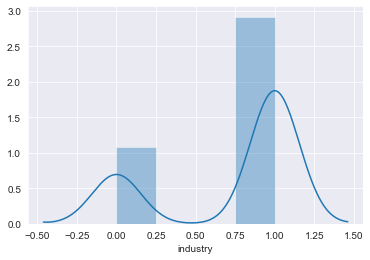

In [11]:
# Target variable is binanry in nature. 
print(main_df['industry'].unique())
sns.distplot(main_df['industry'])

In [12]:
main_df.columns

Index(['Year', 'Quarter', 'Accounts Receivable', 'Inventory',
       'Total current assets', 'Total current liabilities',
       'Total liabilities', 'Common Stock', 'Total liabilities and equity',
       'company_name', 'New Deferred Revenue', 'New Property and Equipment',
       'Total Non-Current Assets', 'Total_Assets', 'Non-Current Liabilities',
       'Total Shareholder's Equity', 'Accounts Payables', 'Retained Earning',
       'OCI', 'Accounts_Receivable_missing', 'Common_Stock_missing',
       'Short_term_investments', 'Short_term_investments_missing',
       'Inventory_missing', 'current_ratio', 'quick_ratio', 'debt_ratio',
       'debt_to_equity_ratio', 'equity_multiplier', 'industry'],
      dtype='object')

In [13]:
company_list = main_df.company_name.unique().tolist()

In [14]:
main_df.set_index(['Year', 'Quarter'], drop=True, inplace=True)
main_df.sort_index(ascending=True, sort_remaining= True, inplace=True)

Microsoft


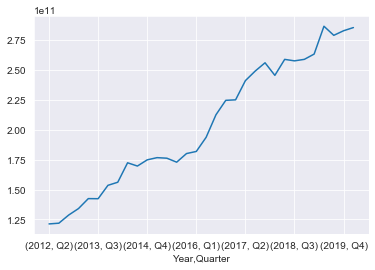

Apple


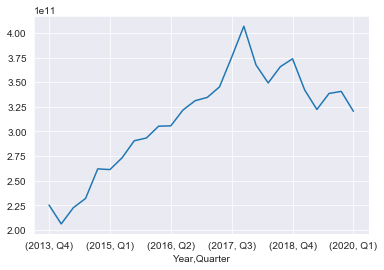

Netflix


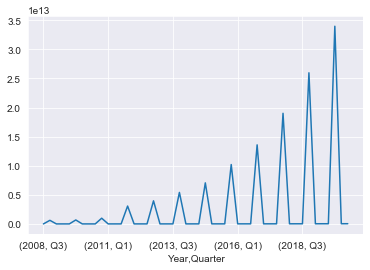

Facebook


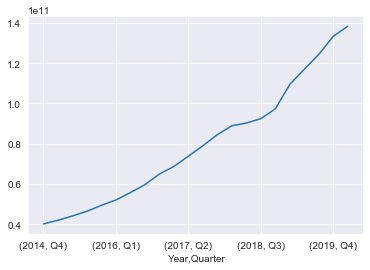

Google


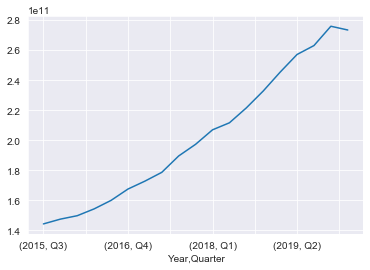

Ford


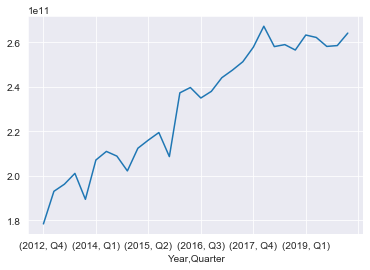

Amazon


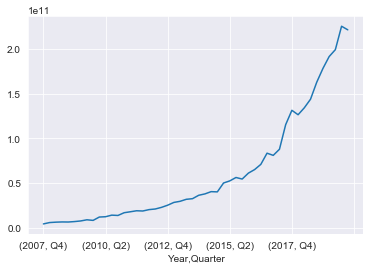

GM


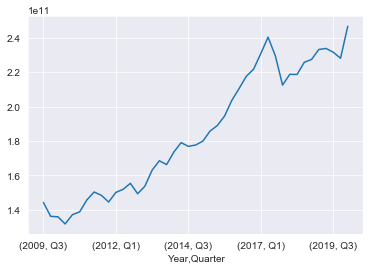

In [15]:
# Assets should increase by time in each company
for company in company_list:
    print(company)
    data = main_df.loc[main_df.company_name == company, 'Total_Assets']
    data.plot()
    plt.show()

# Netflix needs further cleaning?
# main_df.loc[main_df.company_name=='Netflix', 'Total_Assets']

In [16]:
any(main_df['Total liabilities and equity'] == main_df['Total_Assets']) == False

False

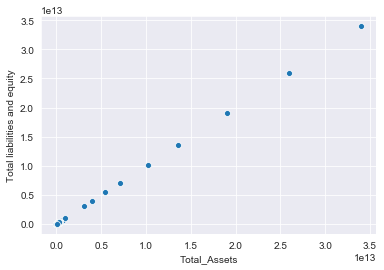

In [17]:
x = main_df['Total_Assets']
y = main_df['Total liabilities and equity']
sns.scatterplot(x, y)

In [18]:
# main_df.loc[main_df.company_name=='Netflix', 'Total_Assets']

In [19]:
# non-integer-and-float data types will be dropped from the dataframe.
main_df.dtypes

Accounts Receivable               float64
Inventory                         float64
Total current assets              float64
Total current liabilities         float64
Total liabilities                 float64
Common Stock                      float64
Total liabilities and equity        int64
company_name                       object
New Deferred Revenue              float64
New Property and Equipment        float64
Total Non-Current Assets          float64
Total_Assets                      float64
Non-Current Liabilities           float64
Total Shareholder's Equity        float64
Accounts Payables                 float64
Retained Earning                  float64
OCI                               float64
Accounts_Receivable_missing         int64
Common_Stock_missing                int64
Short_term_investments            float64
Short_term_investments_missing      int64
Inventory_missing                   int64
current_ratio                     float64
quick_ratio                       

In [20]:
# Take out the categoriacal variables. 
no_cat_list = [name for name in main_df.columns.tolist() if main_df[name].dtypes != object]

In [21]:
no_cat_df = main_df[no_cat_list]

In [22]:
# Take out the indicator variables. 
filtered_list = [name for name in no_cat_df.columns.tolist() if 'missing' not in name]

In [23]:
filtered_df = no_cat_df[filtered_list]

In [24]:
filtered_df.head(2)

,,Accounts Receivable,Inventory,Total current assets,Total current liabilities,Total liabilities,Common Stock,Total liabilities and equity,New Deferred Revenue,New Property and Equipment,Total Non-Current Assets,Total_Assets,Non-Current Liabilities,Total Shareholder's Equity,Accounts Payables,Retained Earning,OCI,Short_term_investments,current_ratio,quick_ratio,debt_ratio,debt_to_equity_ratio,equity_multiplier,industry
Year,Quarter,,,,,,,,,,,,,,,,,,,,,,,
2007,Q4,399000000.0,8.770000e+08,3.373000e+09,2.532000e+09,3.932000e+09,4000000.0,4363000000,277000000.0,457000000.0,139000000.0,4.363000e+09,1.400000e+09,4.310000e+08,1.816000e+09,1.837000e+09,1000000.0,997000000.0,1.332148,0.985782,0.901215,9.122970,10.122970,1.0
2008,Q1,581000000.0,1.077000e+09,3.965000e+09,3.551000e+09,4.413000e+09,4000000.0,5883000000,436000000.0,594000000.0,652000000.0,5.883000e+09,8.620000e+08,1.470000e+09,1.864000e+09,1.232000e+09,7000000.0,655000000.0,1.116587,0.813292,0.750127,3.002041,4.002041,1.0


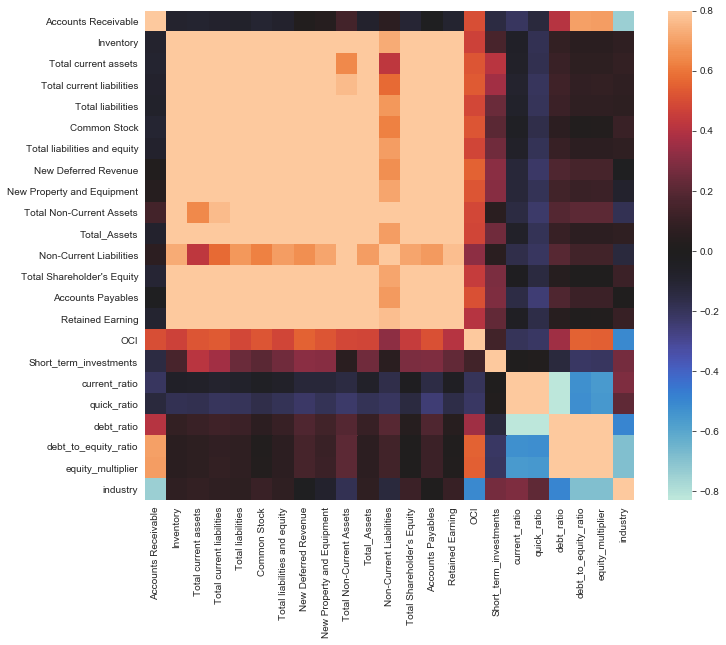

In [25]:
# Heatmap to show correlation among the continuous variable. 
corrmat = filtered_df.corr()
f, ax = plt.subplots(figsize=(12,9))

# Aim: see who is related to who, to increase predicatability and control over-inflated statistical significance. 
sns.heatmap(corrmat, vmax=.8, square=True, center=0)

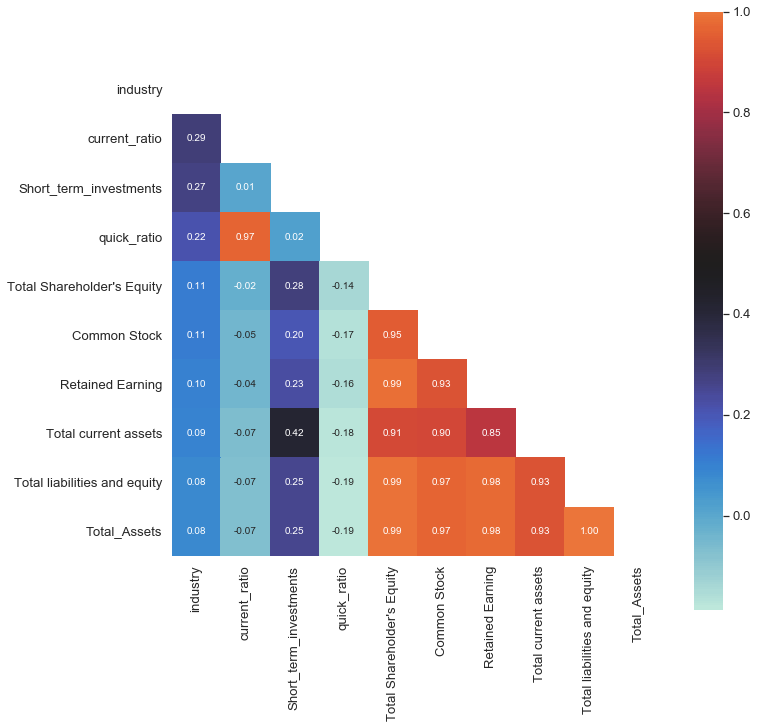

In [26]:
# Zoomed heatmap on highest correlations
# Aim: find multicollinearity copies
k = 10 # number of var for heatmap
cols = corrmat.nlargest(k, 'industry')['industry'].index
cm = np.corrcoef(main_df[cols].values.T)
sns.set(font_scale=1.2)

mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(11,11))
    ax = sns.heatmap(data=cm, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
#                  cmap='YlGn',
                 center=0.5,
                 mask=mask,
                 annot_kws={'size':10}, 
                 yticklabels=cols.values, 
                 xticklabels=cols.values)
plt.show()


According to the heatmap, these are the variables most correlated with 'industry' is current ratio, this is a Point-Biserial Correlation but still in

- Missing features 'Inventory_missing' & 'Common_Stock_missing' have high correlations with current_ratio and quick_ratio, which is understandable given these ratio calculations are based on inventory but not immediately apprant for missing_values for common stock. This maybe due to the same companies missing common stock data are the same companies with a higher current ratio.

Not surprisingly Common Stock and Retained Earnings are highly correlated with Total Shareholders's Equity.

Now we will zoom in to see the spread of data for associations with low correlations only thereby avoiding multicollinearity (we will achieve this by only displaying of the variables with high correlation.) and will reduce clutter. 

C:\Users\Matthew\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


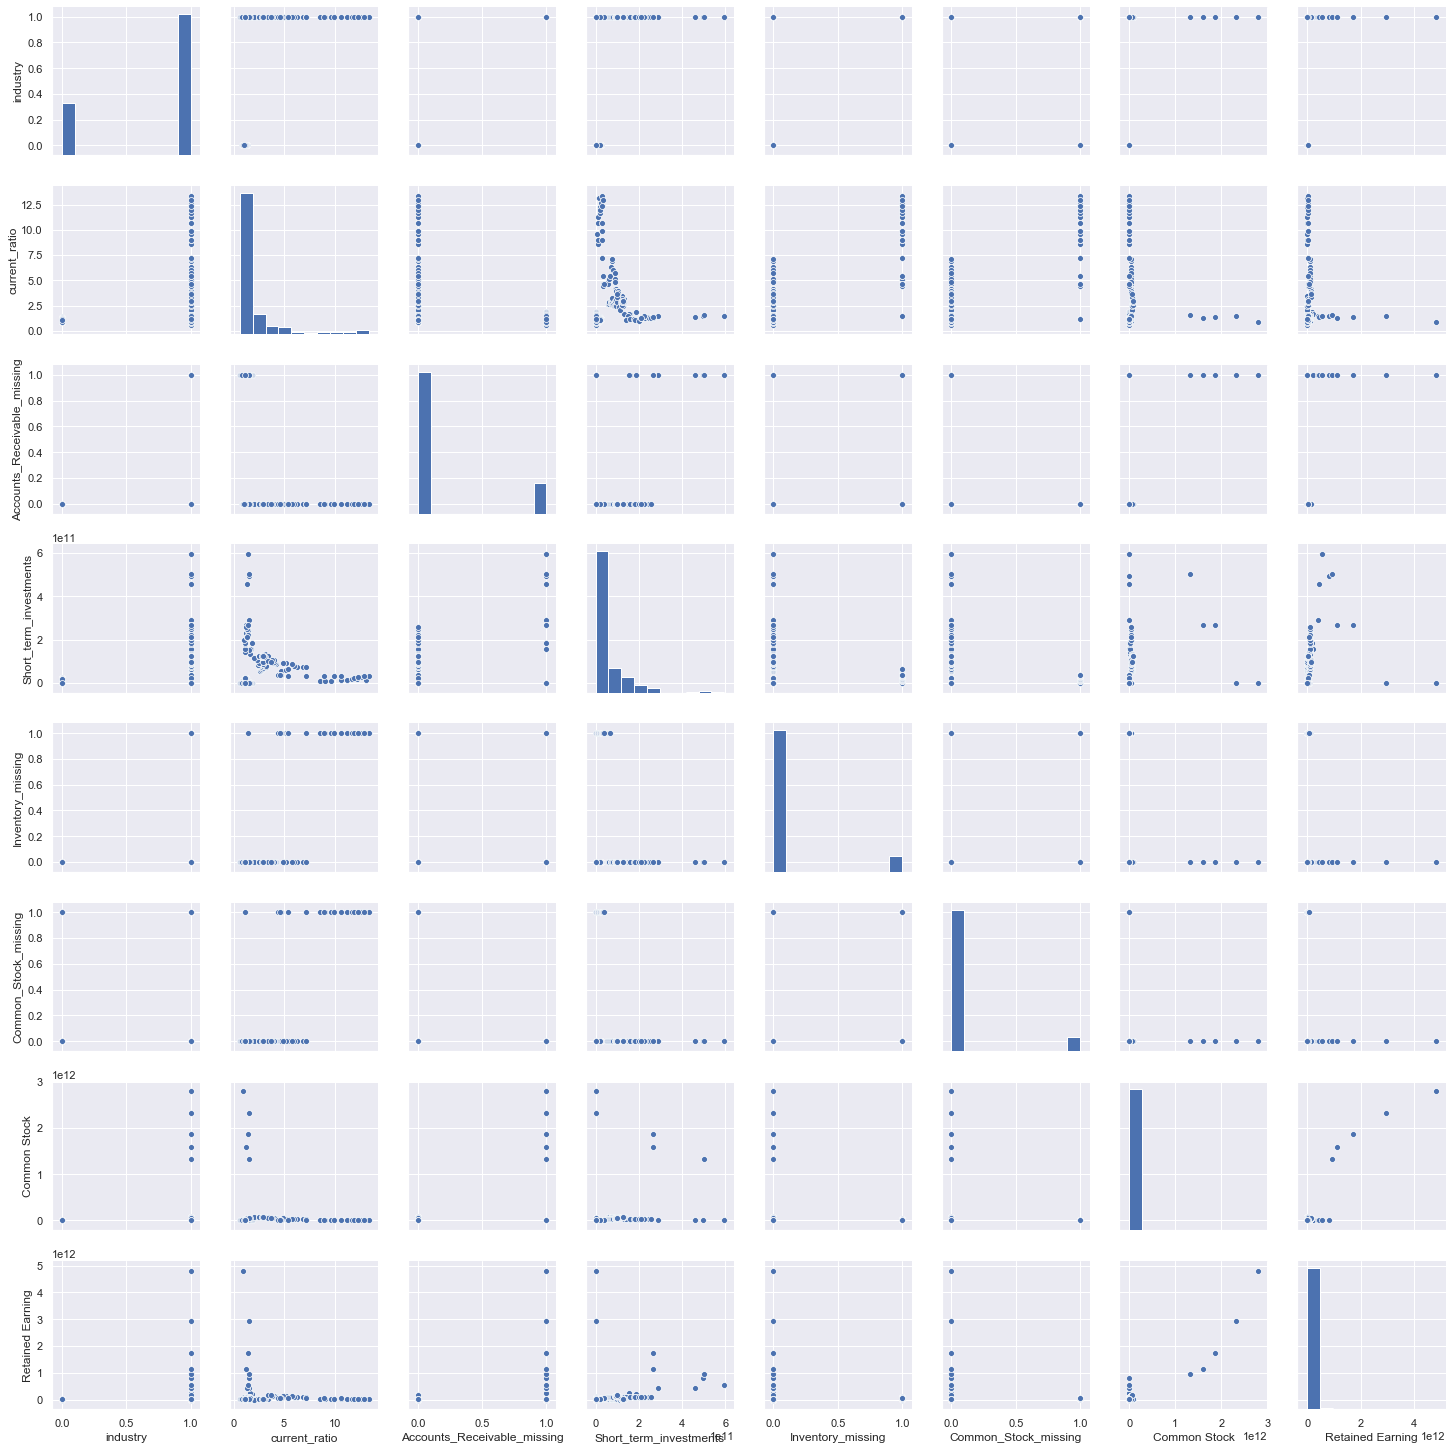

In [27]:
# Scatterplot on non-violating multicollinearity features.
# Aim: Find outliers in the predictors and assure linearity between predictors.
sns.set()
cols = ['industry', 'current_ratio', 'Accounts_Receivable_missing',
       'Short_term_investments', 'Inventory_missing',
       'Common_Stock_missing',  'Common Stock',
       'Retained Earning']

sns.pairplot(main_df[cols], size = 2.5)
plt.show()

Unfortunately our statistical power is too small and maybe limited by the research questions itself to show the typical bloom of insights provided by scatterplots. <br/>
Or the relationships cannot be visually determined by scatterplots. <br/>
However we do see interesting 'exponential-like' relationships between (current-ratio & Short_term_investments)


### Feature Selection 

#### Recursive feature elimination with cross-validation
sklearn.feature_selection.RFECV

In [28]:
from sklearn.feature_selection import RFECV
import sklearn.linear_model as lm

In [29]:
X = main_df.drop(axis=1, columns=['company_name','industry'])
print(X.shape)
y = main_df.industry

(270, 26)


 Let's say we want to shave off bottom three predictors or the 23 most 'helpful' predictors. </br>
 We can specify this number by assigning a value to min_features_to_select.

In [30]:
estimator = lm.LogisticRegression()
selector = RFECV(estimator,  step=0.1, cv=3, n_jobs=-1, min_features_to_select=23)
selector = selector.fit(X,y)
print(selector.support_)
print(selector.n_features_)

[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True]
23


C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warnin

In [31]:
selector.ranking_

array([3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 1])

In [32]:
selector.get_params()

{'cv': 3,
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(),
 'min_features_to_select': 23,
 'n_jobs': -1,
 'scoring': None,
 'step': 0.1,
 'verbose': 0}

In [33]:
X.columns

Index(['Accounts Receivable', 'Inventory', 'Total current assets',
       'Total current liabilities', 'Total liabilities', 'Common Stock',
       'Total liabilities and equity', 'New Deferred Revenue',
       'New Property and Equipment', 'Total Non-Current Assets',
       'Total_Assets', 'Non-Current Liabilities', 'Total Shareholder's Equity',
       'Accounts Payables', 'Retained Earning', 'OCI',
       'Accounts_Receivable_missing', 'Common_Stock_missing',
       'Short_term_investments', 'Short_term_investments_missing',
       'Inventory_missing', 'current_ratio', 'quick_ratio', 'debt_ratio',
       'debt_to_equity_ratio', 'equity_multiplier'],
      dtype='object')

In [34]:
X.columns[selector.get_support()]

Index(['Total current assets', 'Total current liabilities',
       'Total liabilities', 'Common Stock', 'Total liabilities and equity',
       'New Deferred Revenue', 'New Property and Equipment',
       'Total Non-Current Assets', 'Total_Assets', 'Non-Current Liabilities',
       'Total Shareholder's Equity', 'Accounts Payables', 'Retained Earning',
       'OCI', 'Accounts_Receivable_missing', 'Common_Stock_missing',
       'Short_term_investments', 'Short_term_investments_missing',
       'Inventory_missing', 'current_ratio', 'quick_ratio',
       'debt_to_equity_ratio', 'equity_multiplier'],
      dtype='object')

In [35]:
selector.get_support()

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True])

Converesly, if we want to see how well each additional of a predictor contributes to the accuracy of the classification, we can plot a graph that shows the diminishing returns of each additional predictor. 

In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warnin

Optimal number of features : 10


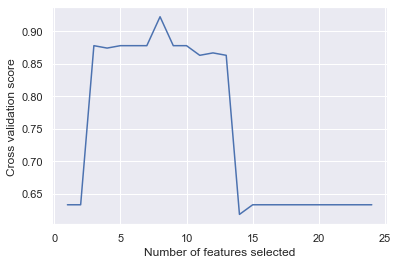

In [37]:
rfecv = RFECV(estimator=estimator, step=1, cv=StratifiedKFold(2),
              scoring='accuracy', min_features_to_select=3)
rfecv = rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score ")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [38]:
# According to RFECV method the following features only can produce the highest CV scores (highest number of correct classification.)
X.columns[rfecv.get_support()]

Index(['New Deferred Revenue', 'New Property and Equipment',
       'Total Non-Current Assets', 'Total_Assets', 'Non-Current Liabilities',
       'Total Shareholder's Equity', 'Accounts Payables', 'Retained Earning',
       'OCI', 'Short_term_investments'],
      dtype='object')

Although the evidence suggested by RFECV recommends 10 predictors, we will keep this in mind and experiment with having a **full_X_train** set versus a **selected_10_train_set**.

#### Assumptions of Hypothesis-testing will be investigated step-wise, ie after each test-result.

Must click to check assumption testing for regression, how autoregression and Homoscedasticity and multicollinearity are related
https://www.analyticsvidhya.com/blog/2016/07/deeper-regression-analysis-assumptions-plots-solutions/#:~:text=An%20additive%20relationship%20suggests%20that,phenomenon%20is%20known%20as%20Autocorrelation.&text=Absence%20of%20this%20phenomenon%20is%20known%20as%20multicollinearity.

##### H<sub>A</sub> residuals are autocorrelated
H<sub>0</sub> Absence of correlation among residual errors</br>
ref: https://www.statology.org/durbin-watson-test-python/#:~:text=One%20of%20the%20assumptions%20of,no%20correlation%20between%20the%20residuals.&text=One%20way%20to%20determine%20if,the%20residuals%20of%20a%20regression.

In [ ]:
# Durbin-Watson Test


##### Homoscedasticity
###### - equal levels of variance across the range of predictor variable (Scatterplot)

-  Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, </br>large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).
    

## Data Preprocessing

In [ ]:
#  Delete columns that will not be needed in Experiment 1.1.
main_df_1_1 = main_df.copy()
main_df_1_1.drop('Filing/Acc.No.', axis=1, inplace=True)
main_df_1_1.drop('company_name', axis=1, inplace=True)

In [ ]:
#  Delete columns that will not be needed in Experiment 1.2.
main_df_1_2 = main_df.copy()
main_df_1_2.drop('Filing/Acc.No.', axis=1, inplace=True)

In [ ]:
print(main_df.shape)
print(main_df_1_1.dtypes)
print(main_df_1_2.shape)

A comparison of results between Scikit-Learn built-in preprocessing methods and Brown's transformation on Tesla_dataframe is provided in the appendix. Scikit-Learns methodology proved to 

#### Normalization
Normality need not to be assumed, let's see how the model performs first. We will try this if the unknown pattern cannot be mapped under the current parameter settings.

##### Normality testing 
###### Histogram 

Microsoft


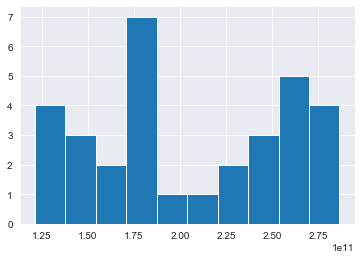

Apple


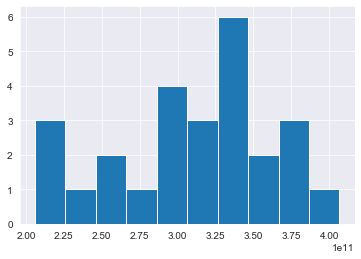

Netflix


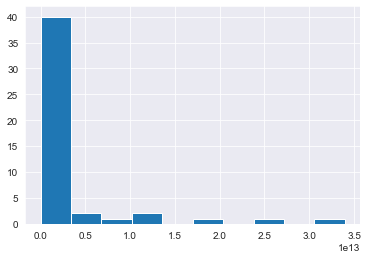

Facebook


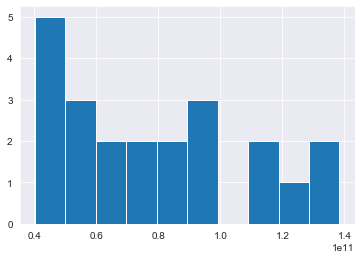

Google


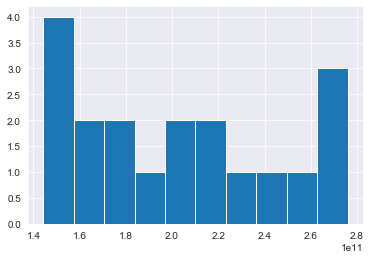

Ford


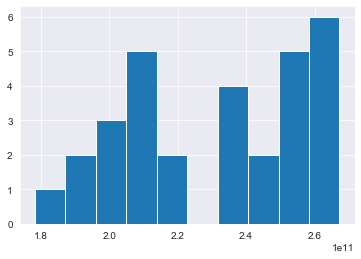

Amazon


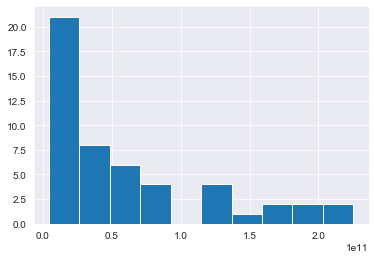

GM


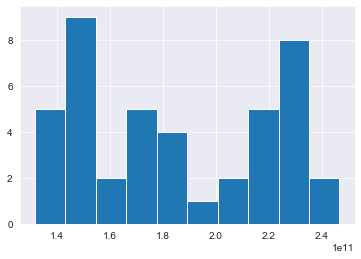

In [41]:
# dist. of total_assets_liabities should hv normal dist in each industry (x-axis=frequency, y-axis=Total_assets_liabilities)
for company in company_list:
    print(company)
    data = main_df.loc[main_df.company_name == company, 'Total_Assets']
    data.hist()
    plt.show()

###### Testing distribution 

In [38]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
#         print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [39]:
for company in company_list:
    print(company)
    data = main_df.loc[main_df.company_name == company, 'Total_Assets']
    get_best_distribution(data) 
    print()

Microsoft


C:\Users\Matthew\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:1678: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))
C:\Users\Matthew\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Best fitting distribution: norm
Best p value: 0.33840840831389996
Parameters for the best fit: (203903812500.0, 52949141153.58571)

Apple
Best fitting distribution: genextreme
Best p value: 0.9050776585019191
Parameters for the best fit: (0.44921635296485074, 297900429340.9983, 55197862250.25093)

Netflix
Best fitting distribution: pareto
Best p value: 0.11302752473245337
Parameters for the best fit: (0.242817350071899, -1108680.3019976565, 493239680.3019936)

Facebook
Best fitting distribution: norm
Best p value: 0.9188963860883852
Parameters for the best fit: (79654318181.81818, 29906252724.725044)

Google
Best fitting distribution: norm
Best p value: 0.8718978415215498
Parameters for the best fit: (202585000000.0, 43825707039.06195)

Ford
Best fitting distribution: norm
Best p value: 0.3824977986064515
Parameters for the best fit: (231373300000.0, 26701976403.941837)

Amazon
Best fitting distribution: weibull_min
Best p value: 0.9836372269361477
Parameters for the best fit: (0.79478

Decided to use Brown's method.

Inversion would not make sense in our case since we are not predicting variables as assumed in the Brown article, and we are not comparing a model performance (predictive or classifier or otherwise). 

***Here transforming acheives only one goal to standardise our different companies, so that reported financials can be compared directly accross companies.***

Brown Article on Time-Series Data Transformation for Machine Learning - https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/#:~:text=Stationary%20Time%20Series,-The%20observations%20in&text=Time%20series%20are%20stationary%20if,the%20variance%20of%20the%20observations.

In [ ]:
def brown_transform(col_name, s, window):
    # Create a list to hold parameter information before transformation.
    para_list = []
    
    # Each Series -> variable s
    s = df[col_name]

    # Power Transform
    try:
        result, lmbda = boxcox(s)
#         print('box_cox')
#         print(lmbda)
        para_list.append(['B-C', lmbda])
        
    except ValueError:
        result, lmbda = yeojohnson(s.values.reshape(-1,1))
#         print('Yeo-Johnson')
        
        if type(lmbda) == np.float64:
            para_list.append(['Y-J', lmbda])
            
        else:
    #         print(f'lambda {lmbda} {type(lmbda)}')
            lmbda = lmbda[0]
            para_list.append(['Y-J', lmbda])
        
    # Difference Transform
    diff_res = difference(result, window)

    # StandardScaler
    # Turn 1-D array of lists into a 2-D array 
    diff_res = np.array(diff_res).reshape(len(diff_res), 1)
    
    para_list.append(np.mean(diff_res))
    para_list.append(np.std(diff_res))
    
    standard_res = StandardScaler().fit_transform(diff_res)

    # Normalization
#     para_list.append(min(standard_res)[0])
#     para_list.append(max(standard_res)[0])
    
    norm_res = MinMaxScaler(feature_range=(1,2)).fit_transform(standard_res)
    norm_res = [ s[0] for s in norm_res]
    trans_para_.update({ col_name : para_list} )
    
    return norm_res

The above preprocessing steps do not require a GridSearch to optimise parameter tuning. 

**Power Transform:** Boxcox() automates the lambda parameter by maximising  the log likelihood function for non-negative power transformations.

Since our data contains negative, zero-values, and postive values. BoxCox limitations in negative numerals is handled by Y-J; while zero values are handled by BoxCox which cannot be handled by Y-J.

**Difference Transform** Utilises the value difference between t=0 and t+=interval to smooth out trends and seasonality. Since our data is quarterly based, interval = 4.

**StandardScaler** Uses the mean and sd to normalise the data with zero mean and unit variance. 

**Normalization** Scales the data to fit with a predefined range (usually 0-1) for better comparison. 

Therefore, parameter tuning for preprocessing steps is unnecessary.

In order to prevent data leakage we will split the training and testing data first and apply training preprocessing parameters to the test set. 

### Isolate Train-model-data (non-Tesla Data) from data of interest (Tesla Data).

In [ ]:
tesla_df_1_1 = main_df_1_1[main_df_1_1['industry'].isna()]
tesla_df_1_1.shape

## Old Tests Feature Selection
3 Methods: <br/>
**Categorical Feature Selection**<br/>
**Numerical Feature Selection — Regression Problem**<br/>
**Wrapper** 

Wrapper Method
sklearn.feature_selection.RFECV <br/>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

Example<br/>
https://towardsdatascience.com/how-to-find-the-best-predictors-for-ml-algorithms-4b28a71a8a80

#### Train_df

In [ ]:
Train_df_1_1 = main_df_1_1[main_df_1_1['industry'].notna()]
Train_df_1_1.shape

#### Train_df

In [ ]:
# Create separate object for target variable
y = Train_df_1_1.industry

# Create separate object for input features
X = Train_df_1_1.drop('industry', axis=1)

In [ ]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1234,
                                                    stratify=Train_df_1_1.industry)

# Print number of observations in X_train, X_test, y_train, and y_test
print( len(X_train), len(X_test), len(y_train), len(y_test) )

In [ ]:
X_test.sort_index(ascending=True, sort_remaining= True, inplace=True)
X_test.shape

In [ ]:
X_train.sort_index(ascending=True, sort_remaining= True, inplace=True)
X_train.shape

<a id='expt1.1'></a>

## (Exploratory) Factor Analysis 

Factor Analysis
    https://www.researchgate.net/post/What_is_the_concept_of_Total_Variance_Explained_in_Factor_Analysis_and_how_can_it_be_used

Exploratory Factor Analysis (Principal Axis Factoring vs. Principal Components Analysis) in SPSS
    https://www.youtube.com/watch?v=5KN_CTgviYs&list=PLdlFfrVsmlvD59VY7hwIfxtCjDoELpknK

# Experiment 1.1 - grouping all companies as a whole for one transformation
<a href='#top'>Top of Page</a>

### 1) Transforming Tech Industry training_dfs

In [ ]:
df = X_train
# Create dictionary to save the transformation parameters.
trans_para_ = {}

transformed_df_list = []

# Apply to all training columns. 
for col_name in df.columns:
        
    # Apply only to numeric columns. 
    if df[col_name].dtypes == 'float64':
            
        s = df[col_name]
        
        # Brown's Transformation Suggestions
        result = brown_transform(col_name, s, 4)
        
        transformed_df = pd.DataFrame({col_name:result}, index=df.index[4:] )
        
        transformed_df.plot(kind='line')
        transformed_df_list.append(transformed_df)
        
        print(col_name)
        plt.show()
        

In [ ]:
new_X_train = pd.concat(transformed_df_list, axis=1)

## <!>Transform only skewed data 
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/comments
- the code skewness = skewness[abs(skewness) > 0.75] should be wrote as skewness = skewness[abs(skewness.Skew)>0.75]<br/>

**Check the skew of all numerical features**<br/>
- <code>skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)<code/>
    
    
src: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

### Implement the training transformations onto X_test with trans_para_.

In [ ]:
# X_test_new = scaler.transform(X_test)
X_test_new_list = []
for col, parameters in trans_para_.items():
    
    power_T = parameters[0][0]
    
    lmbda = parameters[0][1]
    
    mean_ = parameters[1]
    
    std_ = parameters[2]
    
    s = X_test[col]
#     s.plot(title=col)
#     plt.show()
    
    # Power Transformation
    if power_T == 'B-C':
        result = boxcox(s, lmbda)
        
    elif power_T == 'Y-J':
        result = yeojohnson(s, lmbda)
    
    # Difference Transformation
    diff_res = difference(result, 4)
    
    # StandardScaler 
    diff_res = np.array(diff_res).reshape(len(diff_res), 1)
    standard_res = StandardScaler(with_mean = mean_, 
                                 with_std = std_ ).fit_transform(diff_res)
    
    # Normalization
    norm_res = MinMaxScaler(feature_range=(1,2)).fit_transform(standard_res)
    norm_res = [ s[0] for s in norm_res]
    
    df = pd.DataFrame(dict({col: norm_res}), index=s.index[4:])
    X_test_new_list.append(df)
    
#     X_test_new.plot(title=col)
#     plt.show()
    

In [ ]:
new_X_Test = pd.concat(X_test_new_list, axis=1)
new_X_Test.head()

Below is a visual illustration of what happens when we transform our data using brown_transform(). 

<img src='before_and_after_transformation.png'>

<a id='pipe&Hyper'></a>
### Pipeline and Hyperparameters
<a href='#top'>Top of Page</a>

[Expt 2.2 - Train Model](#expt2.2train)

In [ ]:
# Pipeline dictionary Classifiers
pipelines = {
    'l1' : make_pipeline(LogisticRegression(penalty='l1', random_state=123)),
    'l2' : make_pipeline(LogisticRegression(penalty='l2', random_state=123)),
    'rf' : make_pipeline(RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(GradientBoostingClassifier(random_state=123))
}

In [ ]:
# Logistic Regression hyperparameters
l1_hyperparameters = {
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
}

l2_hyperparameters = {
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
}

# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf': [1, 3, 5, 10]
}

# Boosted Tree hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

In [ ]:
# Create hyperparameters dictionary
hyperparameters = {
    'l1' : l1_hyperparameters,
    'l2' : l2_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

## Fit and Tune Model with Cross-Validation

In [ ]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(new_X_train, y_train[4:])
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

In [ ]:
for name, model in fitted_models.items():
    pred = model.predict_proba(new_X_Test)
    pred = [p[1] for p in pred]
    
    print( name, roc_auc_score(y_test[4:], pred) )

Plot the highest AUROC score.

In [ ]:
# Predict PROBABILITIES using L1-regularized logistic regression
pred = fitted_models['l2'].predict_proba(new_X_Test)

# Get just the prediction for the positive class (1)
pred = [p[1] for p in pred]

# Display first 10 predictions
print( np.round(pred[:10], 2) )

In [ ]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test[4:], pred)

In [ ]:
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The above shows the classification where tech is the positive class.

Now reversing the positive class from the Tech industry to Automobile. 


In [ ]:
def swapping_targets(y):
    swapped_y_list = []

    for value in y.values:

        if value == 1:
            swapped_y_list.append(0)

        if value == 0:
            swapped_y_list.append(1)
            
    swapped_y = pd.Series(swapped_y_list, index=y.index)
    
    return swapped_y

In [ ]:
new_y_train = swapping_targets(y_train)

In [ ]:
new_y_test = swapping_targets(y_test)

In [ ]:
# Create empty dictionary called fitted_models
fitted_models_2 = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(new_X_train, new_y_train[4:])
    
    # Store model in fitted_models[name] 
    fitted_models_2[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

In [ ]:
for name, model in fitted_models_2.items():
    pred = model.predict_proba(new_X_Test)
    pred = [p[1] for p in pred]
    
    print( name, roc_auc_score(new_y_test[4:], pred) )

Swapping 0 and 1 produces the same results except for l1. 

In [ ]:
# Predict PROBABILITIES using L1-regularized logistic regression
pred = fitted_models_2['l2'].predict_proba(new_X_Test)

# Get just the prediction for the positive class (1)
pred = [p[1] for p in pred]

# Display first 10 predictions
print( np.round(pred[:10], 2) )

In [ ]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(new_y_test[4:], pred)

In [ ]:
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# https://stackoverflow.com/questions/52373318/how-to-compare-roc-auc-scores-of-different-binary-classifiers-and-assess-statist

## Expt 1.1 Conclusion
We will not try classifying Tesla into the models under these preprocessing conditions, because the predictability of the model is as good as chance.


<a id='expt1.2'></a>

# Experiment 1.2 - individually transforming within companies across the same time-frame
<a href='#top'>Top of Page</a>

In [ ]:
tesla_df_1_2 = main_df_1_2[main_df_1_2['industry'].isna()]
Train_df_1_2 = main_df_1_2[main_df_1_2['industry'].notna()]

In [ ]:
# Create separate object for target variable
y = Train_df_1_2.industry

# Create separate object for input features
X = Train_df_1_2.drop('industry', axis=1)

In [ ]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1234,
                                                    stratify=Train_df_1_2.industry)

# Print number of observations in X_train, X_test, y_train, and y_test
print( len(X_train), len(X_test), len(y_train), len(y_test) )

In [ ]:
X_test.sort_index(ascending=True, sort_remaining= True, inplace=True)
X_train.sort_index(ascending=True, sort_remaining= True, inplace=True)

In [ ]:
company_list = [name for name in X_train.company_name.unique()]

In [ ]:
df_lst = []
for name in company_list:
    company_df = X_train[X_train['company_name']==name]
    df_lst.append(company_df)

In [ ]:
company_dfs = dict(zip(company_list, df_lst))

In [ ]:
for name, df in company_dfs.items():
    print(name)
    partial_df = df.head(2)
    print(df.shape)
#     ICD.display(partial_df)

new_brown_transform without difference transformation because too little data, seperating into company_df's drastically scarificed more data, expecially in X_test. 

In [ ]:
def new_brown_transform(col_name, s):
    # Create a list to hold parameter information before transformation.
    para_list = []
    
    # Each Series -> variable s
    s = df[col_name]

    # Power Transform
    try:
        result, lmbda = boxcox(s)
#         print('box_cox')
#         print(lmbda)
        para_list.append(['B-C', lmbda])
        
    except ValueError:
        result, lmbda = yeojohnson(s.values.reshape(-1,1))
#         print('Yeo-Johnson')
        
        if type(lmbda) == np.float64:
            para_list.append(['Y-J', lmbda])
            
        else:
    #         print(f'lambda {lmbda} {type(lmbda)}')
            lmbda = lmbda[0]
            para_list.append(['Y-J', lmbda])
        
#     # Difference Transform
#     diff_res = difference(result, window)

    # StandardScaler
    # Turn 1-D array of lists into a 2-D array 
    #diff_res = array(diff_res).reshape(len(diff_res), 1)
    
    para_list.append(np.mean(result))
    para_list.append(np.std(result))
    
    result = np.array(result).reshape(len(result), 1)
    standard_res = StandardScaler().fit_transform(result)

    # Normalization
#     para_list.append(min(standard_res)[0])
#     para_list.append(max(standard_res)[0])
    
    norm_res = MinMaxScaler(feature_range=(1,2)).fit_transform(standard_res)
    norm_res = [ s[0] for s in norm_res]
    trans_para_.update({ col_name : para_list} )
    
    return norm_res

 **Perform columnar transformation on each company-dataframe.**

In [ ]:
# { Company Name : {feat_name : [parameters]} }
company_trans_para = {}

trfm_com_df_lst = []

# For each company
for name, df in company_dfs.items():
    print(name)
    # Create dictionary to save the transformation parameters.
    trans_para_ = {}

    transformed_df_list = []

    # Apply to all training columns within that company.
    for col_name in df.columns:

        # Apply only to numeric columns. 
        if df[col_name].dtypes == 'float64':

            s = df[col_name]

            # Brown's Transformation Suggestions
            result = new_brown_transform(col_name, s)
            
            # Transformed Series 
            transformed_df = pd.DataFrame({col_name:result}, index=df.index )
            transformed_df_list.append(transformed_df)
#             transformed_df.plot(kind='line')
#             print(col_name)
#             plt.show()
            
    # Transformed Dataframe, gluing series tgt
    trans_df = pd.concat(transformed_df_list, axis=1)
    
    # Append transformed df to df_list
    trfm_com_df_lst.append(trans_df)
    
    # Saving transformation parameters. 
    company_trans_para[name] = trans_para_
    
#     if name == 'GM':
#         break

#### new_X_train

In [ ]:
new_X_train = pd.concat(trfm_com_df_lst, axis=0)
print(new_X_train.shape)
new_X_train.head()

### Implement the training transformations onto X_test with trans_para_.


In [ ]:
test_df_lst = []
for name in company_list:
    company_df = X_test[X_test['company_name']==name]
    test_df_lst.append(company_df)

In [ ]:
test_company_dfs = dict(zip(company_list, test_df_lst))

In [ ]:
# Too little data!!!! 
test_company_dfs['Microsoft']['Accounts Receivable']

In [ ]:
# X_test_new = scaler.transform(X_test)
X_test_new_list = []

for company, trans_para_ in company_trans_para.items():
    
    transformed_df_list = []
    
    for col, parameters in trans_para_.items():

        power_T = parameters[0][0]

        lmbda = parameters[0][1]

        mean_ = parameters[1]

        std_ = parameters[2]

        s = test_company_dfs[company][col]

        # Power Transformation
        if power_T == 'B-C':
            try:
                result = boxcox(s, lmbda)
                
            except: 
#                 print('Original s \n', s)
                ss = s.copy()
                ss = np.array([num+1 if num == 0 else num for num in s ])
#                 print('New s \n', s)
                result = boxcox(ss, lmbda) 
                
#                 print(company, 'has a negative value.')
#                 s.plot(title=col)
#                 print(s)
#                 result = boxcox(abs(s), lmbda)
                
        elif power_T == 'Y-J':
            result = yeojohnson(s, lmbda)
           
        # Difference Transformation
#         diff_res = difference(result, 4)
        
        # StandardScaler 
#         diff_res = array(diff_res).reshape(len(diff_res), 1)
        result = np.array(result).reshape(len(result), 1)
    
        try:
            standard_res = StandardScaler(with_mean = mean_, 
                                     with_std = std_ ).fit_transform(result)
        except:
            print(company, col)
            print('wrong?')
            print(result)
            print('after difference() and reshape', diff_res)
        # Normalization
        norm_res = MinMaxScaler(feature_range=(1,2)).fit_transform(standard_res)
        norm_res = [ s[0] for s in norm_res]
        
        # Transformed Series
        transformed_df = pd.DataFrame(dict({col: norm_res}), index=s.index)
        transformed_df_list.append(transformed_df)
        
    # Transformed Dataframe, gluing series tgt, per company
    trans_df = pd.concat(transformed_df_list, axis=1)
    
    # Append transformed df to df_list
    X_test_new_list.append(trans_df)
    
    print(f'{company} is transformed and added.')

In [ ]:
new_X_Test = pd.concat(X_test_new_list, axis=0)
print(new_X_Test.shape)
new_X_Test.head()

We will be using the same pipeline and hyperparameters as experiment 1.1. 
<a id='expt2.2train'></a>

[Click](#pipe&Hyper)
here to view again.


## Fit and Tune Model with Cross-Validation

In [ ]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(new_X_train, y_train)
    
    # Store model in fitted_models[name]
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.') 

In [ ]:
for name, model in fitted_models.items():
    pred = model.predict_proba(new_X_Test)
    pred = [p[1] for p in pred]
    
    print( name, roc_auc_score(y_test, pred) )

## Expt 1.2 Conclusion
Our best classifer did not perform better than chance. Whether we transform the features across multiple industies as a whole or transform within each company. 
However, unlike expt 1.1, expt 1.2 did not perform the difference transformation. This may introduce some confounding variables, but since we did not have enough data, it is a limitation of this study.

# Experiment 2.1 - 2x4 Mixed MANCOVA/ Profile Analysis
<a href='#top'>Top of Page</a>

Homogeneity of variance-covariance matrices</br>
https://www.introspective-mode.org/data-assumption-homogeneity-of-variance-covariance/#:~:text=In%20short%2C%20homogeneity%20of%20variance,in%20MANOVA)

Homogeneity of regression slopes</br>
https://www.introspective-mode.org/assumption-homogeneity-parallelism/

<!> Profile Analysis is a mixed MANOVA:  http://userwww.sfsu.edu/efc/classes/biol710/manova/profileSPSS-Worked-Ex.htm <br/>
Example using SPSS, note SPSS deafults to using type III (focus on Interaction) (Type I sequential; type II assumes no interaction)

Difference between MANOVA and Profile analysis ( PA needs to be on the same scale) <br/>

Three Hypothesis same as MANOVA and Profile Analysis <br/>
H1: MANOVA is called Between Subject (IV) Main Effect (in PA is called Levels hypothesis) The 2 groups are different <br/>
H2: MANOVA is called Within Subject (DV) Main Effect (in PA is called Flatness hypothesis) Difference within a group <br/>
H3: MANOVA is called Interaction (IV & DV) (in PA is called Parallelism (of Profiles) hypothesis)  <br/>


Analyse in SPSS because python statsmodels.api does not have MANCOVA (only MANOVA). We would like to control for the covariate ***Total Assets*** (Elmberger & Makdisi-Somi, 2016)<sup>1</sup> to level the playing field of individuals<sup>2</sup>.

We selected considering our scope of interest is limited to the Balance Sheet, more traditional valuation metrics such as EBITDA (which incorporates the share price) are forgone. Another metric mentioned in the paper is the D&A (Depreciation & Amortization) of the company can be found in the Balance Sheet, however the coherence of reporting the metric is not found accross the companies. For example, Goodwill is a major intangible (amortized) asset in the auto industry but rarely seen in the tech industry. Given these limitations, we settled on selecting the ***Total Assets*** as our covariate. 

Covariates help with increasing statistical validity (controlling for confounding variables).<sup>3</sup> 

<br/>

<sup>1</sup> http://www.diva-portal.org/smash/get/diva2:942663/FULLTEXT01.pdf</br>
<sup>2</sup>http://media.usm.maine.edu/~jbeaudry/Research%20Literacy/Ch%209.pdf</br>
<sup>3</sup>https://www.intechopen.com/books/physical-disabilities-therapeutic-implications/validity-in-rehabilitation-research-description-and-classification

Example of 2 Factor Mixed MANOVA

https://www.slideshare.net/JPVerma3/twofactor-mixed-manova-with-spss

<a id='expt3.1'></a>

# Experiment 3.1 - k-means clustering
<a href='#top'>Top of Page</a>

Does not assume any normality or Stationarity. 

Alternative to k-means clustering, without setting the number of clusters a priori https://en.wikipedia.org/wiki/DBSCAN

<a id='expt4.1'></a>

# Experiment 4.1 - ML Time Series Analysis
<a href='#top'>Top of Page</a>

Stationarity and detrending Test (ADF/KPSS)
https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html



In [ ]:
Sktime

In [ ]:
Time Series ARIMA 

In [ ]:
Prophet https://facebook.github.io/prophet/docs/quick_start.html

<a id='appendix'></a>

https://academic.oup.com/cid/article/45/7/901/543152 <br/>
Comparison of quasi-design experiments two-group tests (t test &  χ2 test), regression (association), and time series

Quasi design susceptible to internal validity (the casual relationship between the IV and DV)

# Appendix
<a href='#top'>Top of Page</a>

## Comparing BoxCox and Y-J have unexpected results

Inventory positive outcome for Y-J, Total current assets negative outcome for Y-J but positive outcome for Box-Cox.

In [ ]:
Inventory = X_train.Inventory
# print(Inventory)
new_inventory, lmbda = yeojohnson(Inventory) 
pd.DataFrame(new_inventory).plot()
plt.show()

In [ ]:
newB_TCA = brown_transform('Total current assets', X_train['Total current assets'], 4)
# pd.DataFrame(newB_TCA).plot()

In [ ]:
TCA = X_train['Total current assets']
TCA.plot()
plt.show()
# print(TCA.describe())
# print(TCA)


In [ ]:
TCA = X_train['Total current assets']
# print(TCA)
new_TCA, lmbda = yeojohnson(TCA) 
# print(lmbda)
# pd.DataFrame(new_TCA).plot()
# plt.show()

## Try Brown's method.

#### Power Transform

In [ ]:
from scipy.stats import boxcox
s = tsla_df['Accounts Receivable']
result, lmbda = boxcox(s)

In [ ]:
s.plot()

In [ ]:
pd.Series(result).plot()

#### Difference Transform

In [ ]:
# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

In [ ]:
diff_res = difference(result, 4)
pd.Series(diff_res).plot()

In [ ]:
sample = difference(power_s, 4)
sample = np.array(sample).reshape(-1, 1) 

In [ ]:
sample_norm = pd.DataFrame(StandardScaler().fit_transform(sample))
sample_norm.plot()

#### StandardScaler 

In [ ]:
from numpy import array
diff_res = [x for x in diff_res]
diff_res = array(diff_res).reshape(len(diff_res), 1)
# print(pd.Series(diff_res[0]).plot())
# plt.show()
standard_res = StandardScaler().fit_transform(diff_res)

In [ ]:
pd.DataFrame(standard_res).plot()
plt.show()

#### Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
norm_res = MinMaxScaler().fit_transform(standard_res)

In [ ]:
pd.DataFrame(norm_res).plot()

## Using Scikit-Learn built-in preprocessing methods, does not yield proper results. 

In [ ]:
# Power Transform
from sklearn.preprocessing import power_transform

# Difference Transform
# Missing

# Standardization
from sklearn.preprocessing import StandardScaler

# Normalization
from sklearn.preprocessing import normalize

In [ ]:
type(s.values)

#### Power Transform

In [ ]:
# Using 'Accounts Receivable' as an example, plot different transformations.
s = tsla_df['Short_term_investments']

power_s = power_transform(s.values.reshape(-1,1), 
                          method='box-cox', 
                          standardize=False)
# print(power_s)

##### Accounts Receivable


In [ ]:
# Original
# Before Power Transformations
print(pd.DataFrame(s).plot())
plt.show()

In [ ]:
# Accounts Receivable
# After Power Transformations - box-cox
print(pd.DataFrame(power_s).plot())
plt.show()

In [ ]:
# Accounts Receivable
# After Power Transformations - yeo-johnson
print(pd.DataFrame(power_s).plot())
plt.show()

##### Short_term_investments

In [ ]:
# Original
# Before Power Transformations
print(pd.DataFrame(s).plot())
plt.show()

In [ ]:
# Short_term_investments
# After Power Transformations - box-cox
 **ERROR - **
ValueError: The Box-Cox transformation can only be applied to strictly positive data

In [ ]:
# Short_term_investments
# After Power Transformations - yeo-johnson
print(pd.DataFrame(power_s).plot())
plt.show()

In [ ]:
power_s = [num[0] for num in power_s]

#### Difference Transform
Same as Brown's


In [ ]:
# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

In [ ]:
diff_s = difference(power_s, 4)
pd.Series(diff_s).plot()

## Normalization

In [ ]:
norm_s = normalize(diff_s, norm='l1', axis=0)
pd.DataFrame(norm_s).plot()

#### Standardization

In [ ]:
diff_s = [[num] for num in diff_s]

In [ ]:
standard_s = StandardScaler().fit_transform(diff_s)
pd.DataFrame(standard_s).plot()

## Comparison of final products between scikit-learn and Brown's process

In [ ]:
norm_s == norm_res
print(type(norm_s), type(norm_res))
norm_s_df = pd.DataFrame( norm_s)
norm_res_df = pd.DataFrame( norm_res)
norm_s_df.plot()
norm_res_df.plot()

<a href='#top'>Top of Page</a>